In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_1251083/1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')

%load_ext autoreload
%autoreload 2
import basic_neural_processing_modules as bnpm
from basic_neural_processing_modules import torch_helpers, h5_handling, timeSeries, similarity, math_functions, misc, decomposition, linear_regression, pickle_helpers, cupy_helpers, plotting_helpers, path_helpers
from GCaMP_ROI_classifier.old_stuff import util

ModuleNotFoundError: No module named 'GCaMP_ROI_classifier.old_stuff'

In [ ]:
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

In [ ]:
def rescaler(list_of_images, scales):
    return [torchvision.transforms.functional.affine(img=torch.as_tensor(list_of_images[ii], dtype=torch.float32),
                                                                                     angle=0,
                                                                                     translate=[0,0],
                                                                                     scale=scales[ii],
                                                                                     shear=0,
                                                                                     interpolation=torchvision.transforms.InterpolationMode('bilinear'),
                                            #                                          fill: Optional[List[float]] = None
                                                                                    ) for ii in range(len(list_of_images))]

def padder(images, new_size, kwargs_center_crop={}):
    return torchvision.transforms.functional.center_crop(torch.as_tensor(images, dtype=torch.float32), output_size=new_size)

# Shih-Yi's data

In [ ]:
SYTdata1 = h5_handling.simple_load('/media/rich/bigSSD RH/other lab data/Harvey_lab_ROIs/ShihYi labeled_cells_for_Rich/trainingData_L5_171228.mat')
SYTdata2 = h5_handling.simple_load('/media/rich/bigSSD RH/other lab data/Harvey_lab_ROIs/ShihYi labeled_cells_for_Rich/trainingData_L23_171216.mat')

In [4]:
SYTdata1.data
SYTdata2.data

NameError: name 'SYTdata1' is not defined

In [5]:
SYTmasks_list = [SYTdata1['alignedMasks'], SYTdata2['alignedMasks']]

NameError: name 'SYTdata1' is not defined

## Place ROIs in 36x36 arrays

In [10]:
new_size = np.array([36, 36])

SYTmasks_list_36x36 = [padder(SYTmasks_list[ii], new_size).numpy() for ii in range(len(SYTmasks_list))]

## Resize ROIs to 250 non-zero pixels average

scaling factors: [1.1115455  1.67833435]


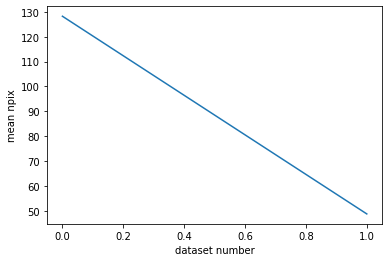

In [11]:
ROI_sizeMean, ROI_sizeStd = [], []

for ii in range(len(SYTmasks_list_36x36)):
    ROI_npix = np.sum(SYTmasks_list_36x36[ii]>0, axis=(1,2))
    ROI_sizeMean.append(np.mean(ROI_npix))
    ROI_sizeStd.append(np.std(ROI_npix))
    
%matplotlib inline
plt.figure()
plt.plot(ROI_sizeMean)
plt.xlabel('dataset number');
plt.ylabel('mean npix');

scale_factors = (((1/np.array(ROI_sizeMean))*200)**(1/2.35)) * 0.92
# scale_factors = 1 + ((175/np.array(ROI_sizeMean))**(1.25) -1)/6.5
# scale_factors = [1,1]
print(f'scaling factors: {scale_factors}')

In [12]:
SYTmasks_list_rescaled = rescaler(SYTmasks_list_36x36, scale_factors)
# SYTmasks_list_rescaled = rescaler(SYTmasks_list_36x36, [1.00001, 1.62])

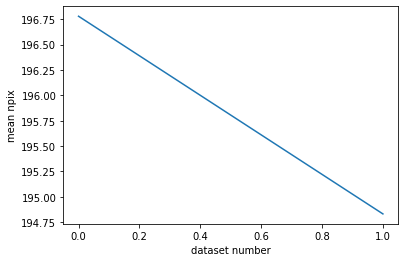

In [13]:
ROI_sizeMean, ROI_sizeStd = [], []

for ii in range(len(SYTmasks_list_rescaled)):
    ROI_npix = np.sum(SYTmasks_list_rescaled[ii].numpy()>0, axis=(1,2))
    ROI_sizeMean.append(np.mean(ROI_npix))
    ROI_sizeStd.append(np.std(ROI_npix))
    
%matplotlib inline
plt.figure()
plt.plot(ROI_sizeMean)
plt.xlabel('dataset number');
plt.ylabel('mean npix');

<IPython.core.display.Javascript object>


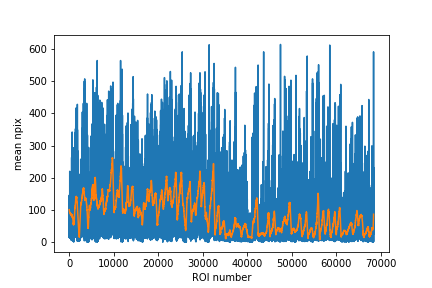

<IPython.core.display.Javascript object>


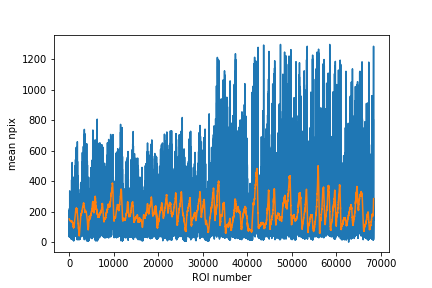

In [15]:
%matplotlib notebook

plt.figure()
plt.plot(np.sum(np.concatenate(SYTmasks_list_36x36) > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(np.concatenate(SYTmasks_list_36x36) > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

plt.figure()
plt.plot(np.sum(np.concatenate(SYTmasks_list_rescaled) > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(np.concatenate(SYTmasks_list_rescaled) > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

### zero sum masks

In [16]:
SYTmasks_list_rescaled_zeroSum = [SYTmasks_list_rescaled[ii] / torch.sum(SYTmasks_list_rescaled[ii], dim=(1,2))[:,None,None] for ii in range(len(SYTmasks_list_rescaled))]

In [17]:
# SYTmasks  = np.concatenate((SYTdata1['alignedMasks'], SYTdata2['alignedMasks']), axis=0)
SYTmasks_final  = np.concatenate(SYTmasks_list_rescaled_zeroSum, axis=0)
SYTlabels = np.concatenate((np.int64(SYTdata1['realLabels'][0]), np.int64(SYTdata2['realLabels'][0])), axis=0)

## Visualize ROIs

<IPython.core.display.Javascript object>


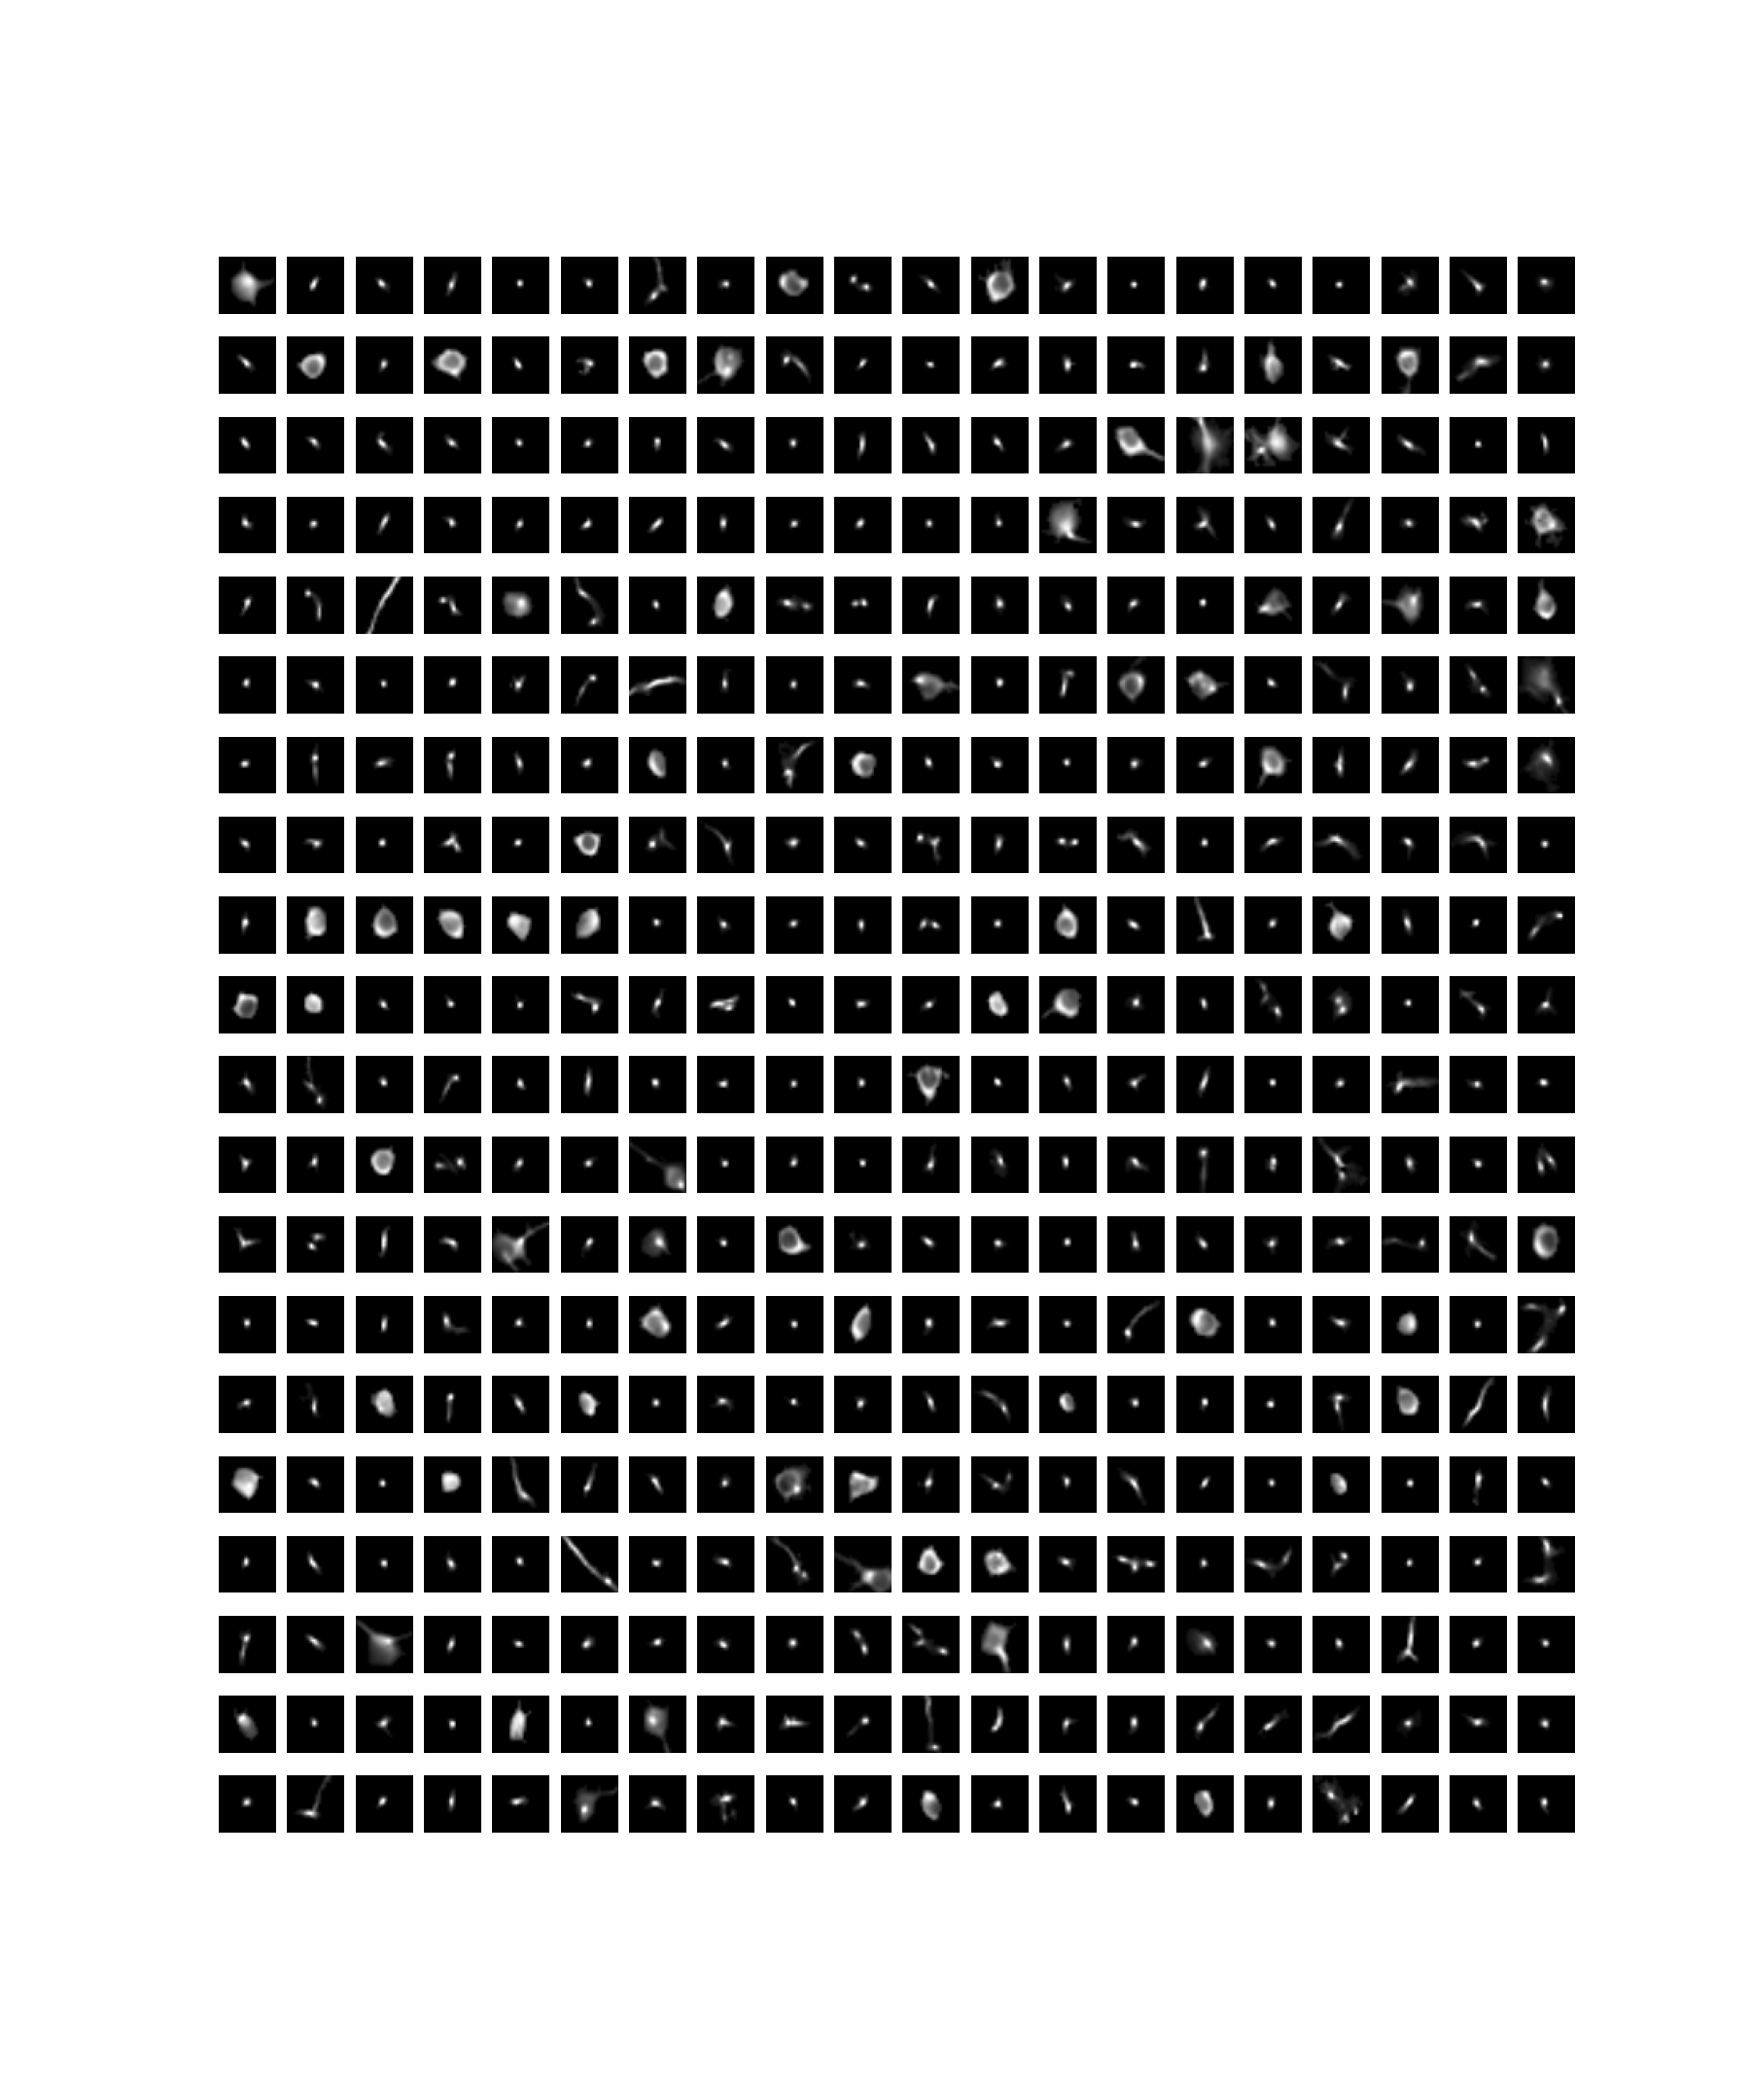

In [18]:
%matplotlib notebook
plotting_helpers.plot_image_grid(images=SYTmasks_list_rescaled_zeroSum[1][0:],
#                                 labels=SYTlabels[20000:],
                                grid_shape=(20,20),
                                show_axis='off',
                                cmap='gray',
                                kwargs_subplots={'figsize':(25,30)},
                                kwargs_imshow={'interpolation':'antialiased'});

# Noah's data

In [19]:
paths_statFiles = path_helpers.get_all_files(root='/media/rich/bigSSD RH/other lab data/Harvey_lab_ROIs/Noah_statFiles/suite2p_stat_dump/')

In [20]:
NPdata = util.import_multiple_stat_files(paths_statFiles=paths_statFiles,
                                         out_height_width=[36, 36],
                                         max_footprint_width=1025,
                                         plot_pref=False)

In [21]:
np.sum(np.array([NPdata[ii].shape for ii in range(len(NPdata))]), axis=0)[0]

453652

## Resize ROIs so they are roughly the same (250 n pix)
resizing done based on average number of pixels for a given recording session

scaling factors: [0.92983686 1.15488124 1.1534139  1.04847255 1.23291647 1.02374695
 0.99004418 1.01482712 0.90973744 0.98171368 0.90155656 0.98782902
 0.93768481 0.86457618 1.01284838 0.97001509 1.00358737 0.94926609
 0.93419171 0.95787246 0.94549221 0.95345604 0.96386484 0.90906233
 0.97365367 0.94067982 0.94012253 0.93266095 0.95800301 0.98140066
 1.04134474 1.24701445 1.32342448 1.19825709 1.38168895 1.43279946
 0.98371517 1.30443441 1.35808443 1.47845682 1.42928806 1.4476856
 1.43492495 1.33088887 1.45431893 1.42989896 1.43955549 1.39497819
 1.40989824 1.4887659  1.4810345  1.43444607 1.5006917  1.41788006
 1.39765567 1.43053749 1.42515347 1.44047767 0.9967849  1.50278753
 1.50664212 1.47229625 1.48773918 1.51340301 1.52614634 1.57263041
 1.52637315 1.43741691 0.97644804 1.29716844 1.42825374 1.4057112
 1.44547854 1.18030366 1.49886627 1.51961961 1.39839766 1.3401702
 1.41677761 1.38712567 1.39266057 1.46352368 1.17859299 1.80881103
 1.39184615 1.4222906  1.12305304 1.52487661 1.5

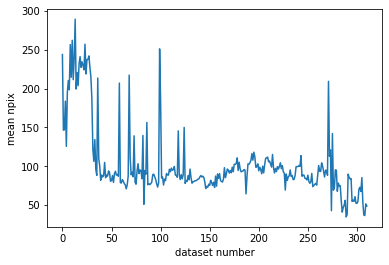

In [22]:
ROI_sizeMean, ROI_sizeStd = [], []

for ii in range(len(NPdata)):
    ROI_npix = np.sum(NPdata[ii]>0, axis=(1,2))
    ROI_sizeMean.append(np.mean(ROI_npix[:1500]))
    ROI_sizeStd.append(np.std(ROI_npix))
    
%matplotlib inline
plt.figure()
plt.plot(ROI_sizeMean)
plt.xlabel('dataset number');
plt.ylabel('mean npix');

scale_factors = (((1/np.array(ROI_sizeMean))*250)**(1/2.35)) * 0.92
# scale_factors = 1 + ((175/np.array(ROI_sizeMean))**(1.25) -1)/6.5
# scale_factors = [1,1]
print(f'scaling factors: {scale_factors}')

In [23]:
NPdata_rescaled = rescaler(NPdata, scale_factors)
# NPdata_rescaled = rescaler(NPdata, [1.00001, 1.62])

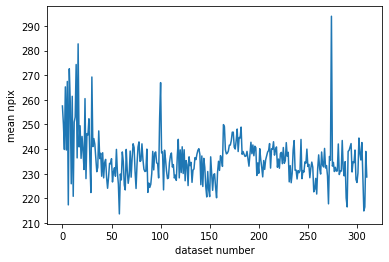

In [24]:
ROI_sizeMean, ROI_sizeStd = [], []

for ii in range(len(NPdata_rescaled)):
    ROI_npix = np.sum(NPdata_rescaled[ii].numpy()>0, axis=(1,2))
    ROI_sizeMean.append(np.mean(ROI_npix[:1500]))
    ROI_sizeStd.append(np.std(ROI_npix))
    
%matplotlib inline
plt.figure()
plt.plot(ROI_sizeMean)
plt.xlabel('dataset number');
plt.ylabel('mean npix');

<IPython.core.display.Javascript object>


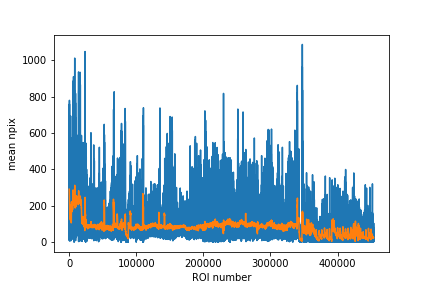

<IPython.core.display.Javascript object>


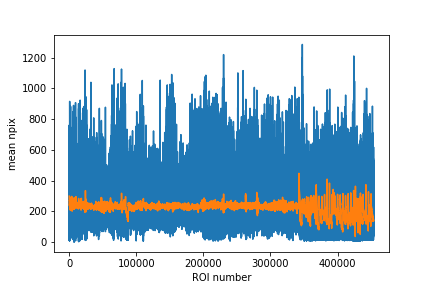

In [25]:
%matplotlib notebook

plt.figure()
plt.plot(np.sum(np.concatenate(NPdata) > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(np.concatenate(NPdata) > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

plt.figure()
plt.plot(np.sum(np.concatenate(NPdata_rescaled) > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(np.concatenate(NPdata_rescaled) > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

## zero-sum masks

In [26]:
NPdata_rescaled_zeroSum = [NPdata_rescaled[ii] / torch.sum(NPdata_rescaled[ii], dim=(1,2))[:,None,None] for ii in range(len(NPdata_rescaled))]

In [27]:
NPmasks_final = np.concatenate(NPdata_rescaled_zeroSum, axis=0)

## Visualize ROIs

<IPython.core.display.Javascript object>


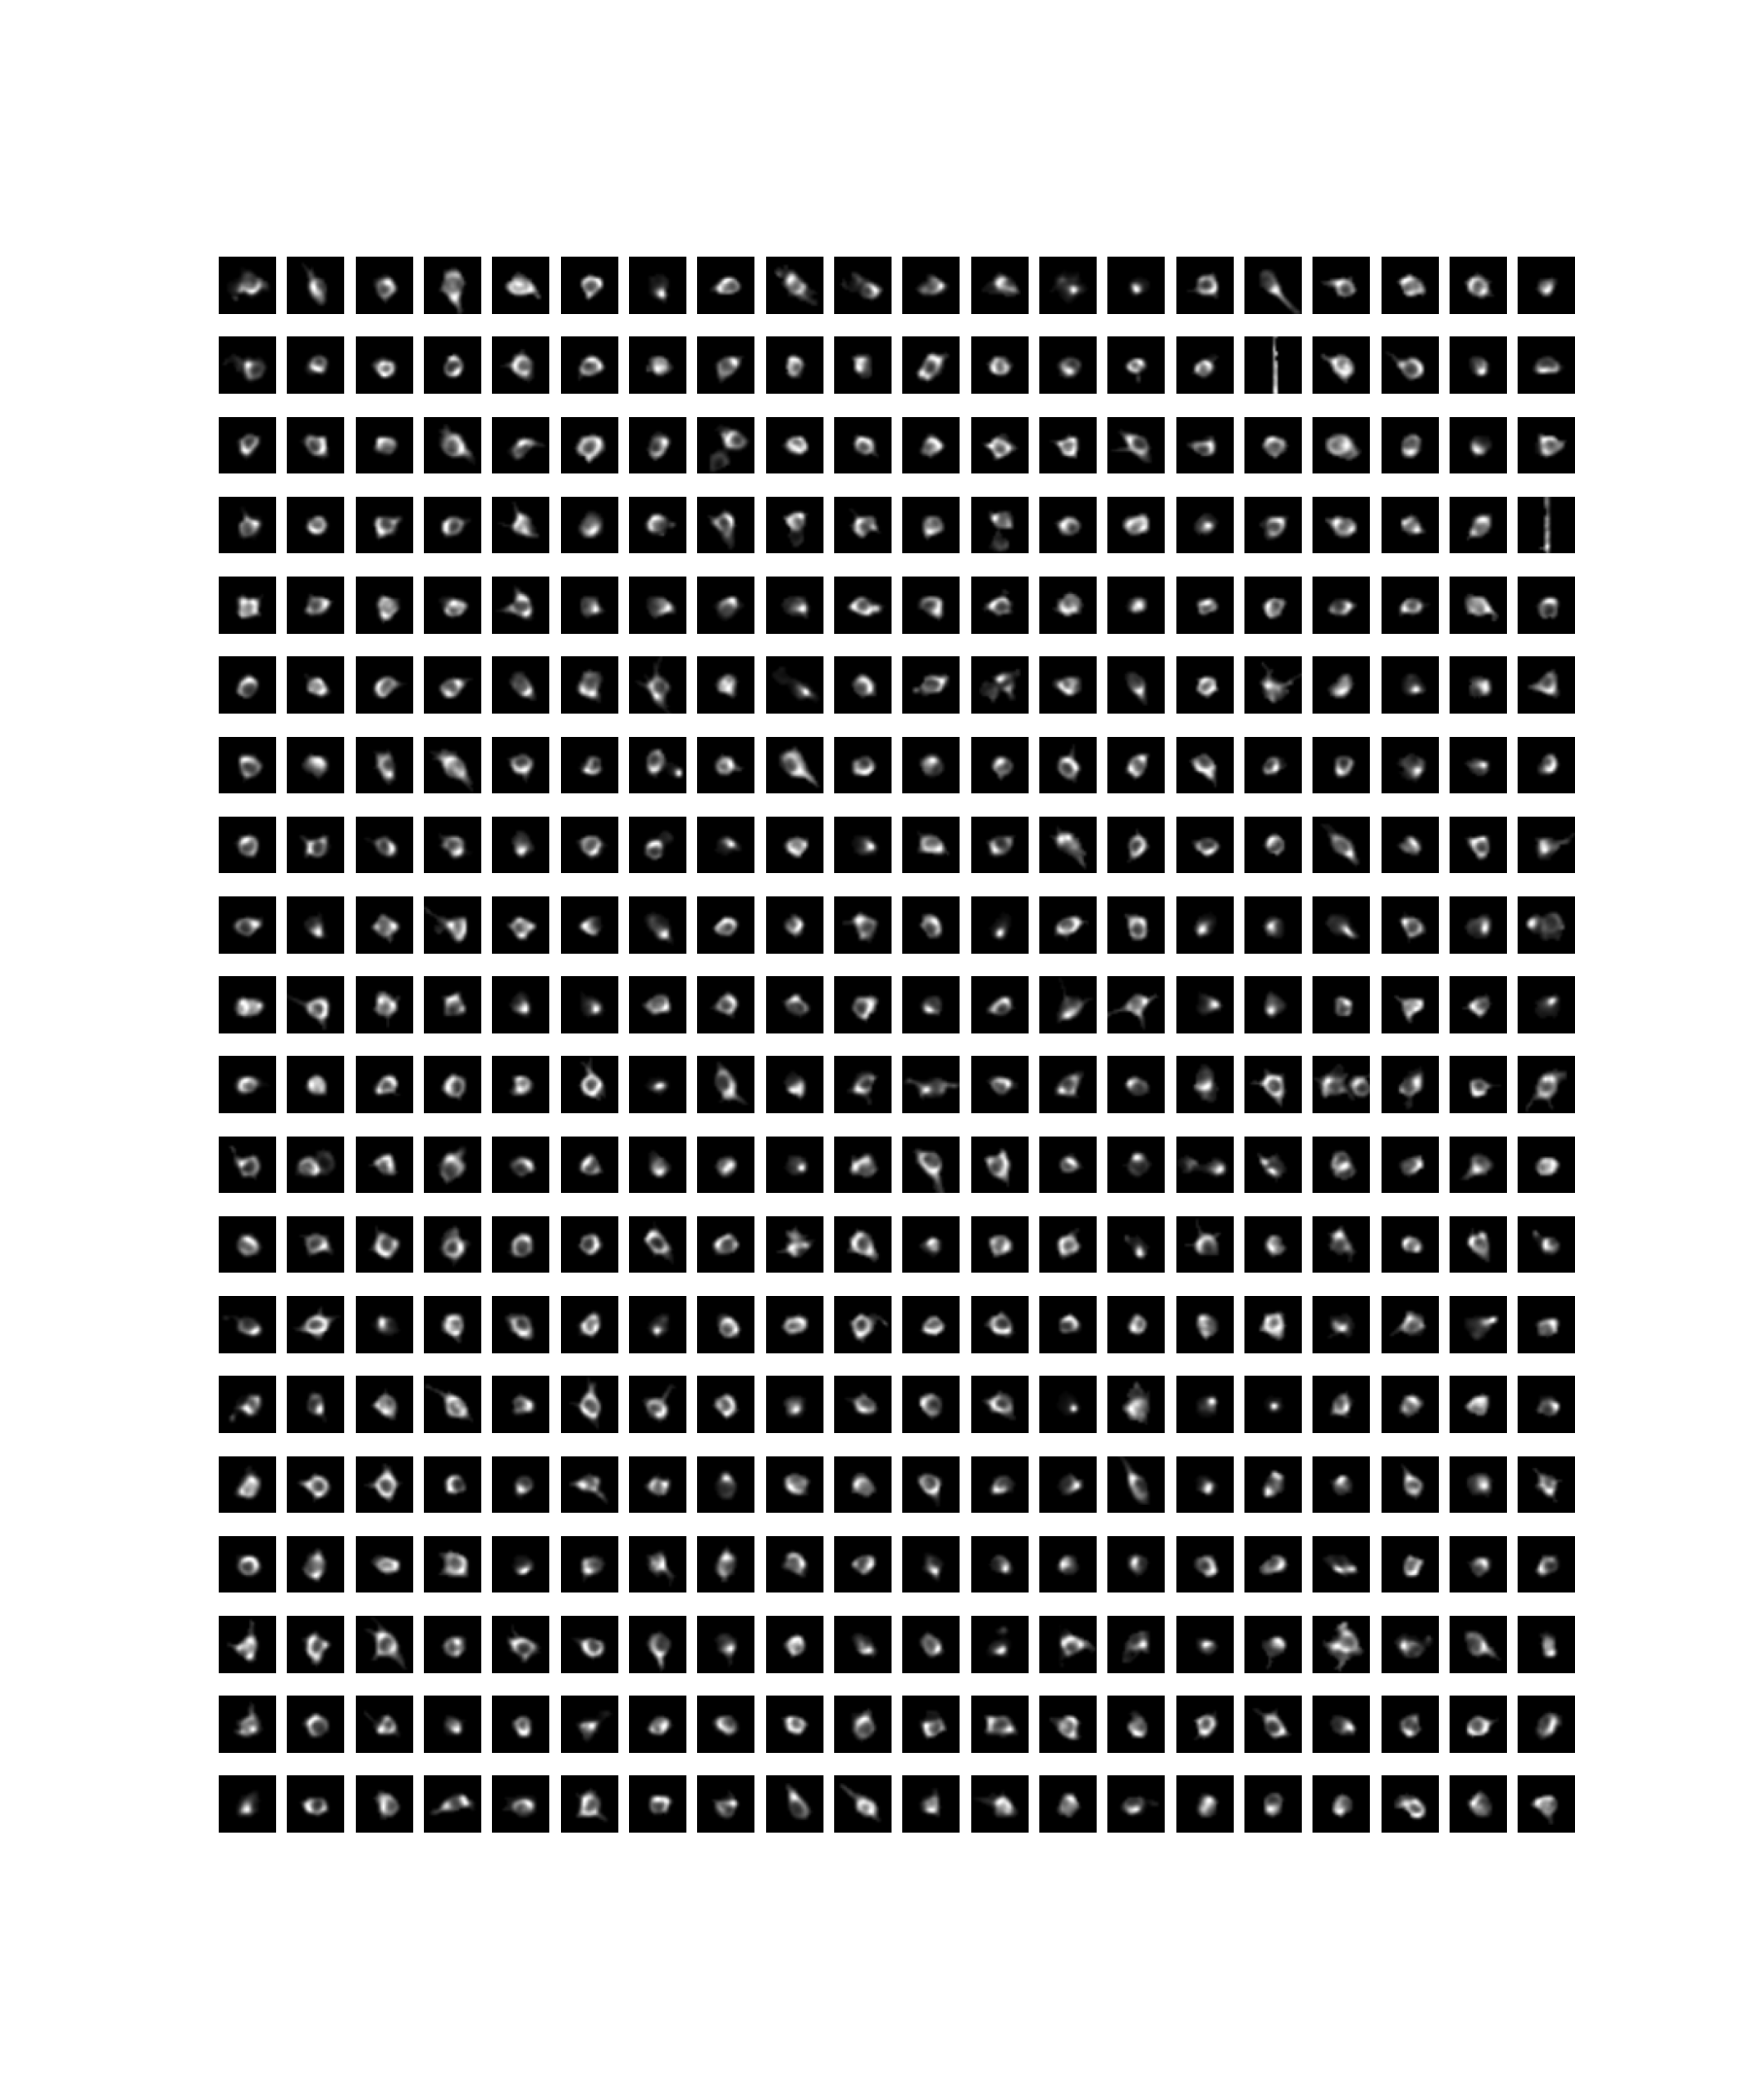

In [30]:
%matplotlib notebook

plotting_helpers.plot_image_grid(images=NPdata_rescaled_zeroSum[85][0:],
#                                 labels=SYTlabels[20000:],
                                grid_shape=(20,20),
                                show_axis='off',
                                cmap='gray',
                                kwargs_subplots={'figsize':(25,30)},
                                kwargs_imshow={'interpolation':'antialiased'});

In [31]:
print(f'size of total SYT masks: {misc.estimate_size_of_float_array(SYTmasks_final)/1000000000} GB')
print(f'size of total NP masks: {misc.estimate_size_of_float_array(NPmasks_final)/1000000000} GB')

size of total SYT masks: 0.354492288 GB
size of total NP masks: 2.351731968 GB


# Rich's data

In [32]:
import pickle

# with open('/Users/Josh/Documents/Harvard/label_data/all_stat_files_20211022.pkl', 'rb') as file:
with open('/media/rich/bigSSD RH/for_Josh/GCAMP_ROI_Classifier_data/label_data/all_stat_files_20211022.pkl', 'rb') as file:
    statFiles_scraped = pickle.load(file)

In [33]:
keys_toDelete = [
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [34]:
sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

images_all = np.concatenate(sf_list, axis=0)

images_all.shape

(217802, 36, 36)

## Resize ROIs so they are roughly the same (175 n pix)
resizing done based on average number of pixels for a given recording session

scaling factors: [1.0208802  0.86836849 0.92638288 0.72671981 0.84431546 0.73576937
 0.6836551  0.71852101 0.65627481 0.68086329 0.65489086 0.6755549
 0.67187554 0.68908852 0.68021639 0.70079507 0.67957296 0.65890005
 0.69396226 0.68196415 0.7095268  0.70428091 0.67135194 0.68431656
 1.7052096  1.76664982 1.77203442 1.78568641 1.71103668 1.70843999
 1.62360184 1.56220035 1.56943209 1.5475739  1.43390531 1.48456839
 1.7841956  1.85765707 1.85122448 2.04370394 1.92517026 2.19618597
 1.72122785 1.88241687 1.71809391 1.67875516 1.0968326  1.05618555
 1.07296942 1.10648267 1.09940308 1.20087149 1.14564811 1.1481115
 1.16349371 1.13098285 0.68342375 0.72145976 0.73095833 0.75138924
 0.70587461 0.72812641 0.70974331 0.69343224 0.68501629 0.62857609
 0.69037862 0.75800438 0.66223899 0.67633004 0.64212241 0.71934506
 0.71894296 0.71868259 0.70583372 0.69638576 0.66753621 0.62491573
 0.66624235 0.7174325  0.6699247  0.64335662 0.6664727  0.65702553
 0.63440476 0.58801388 0.68887388 0.64780085 0.

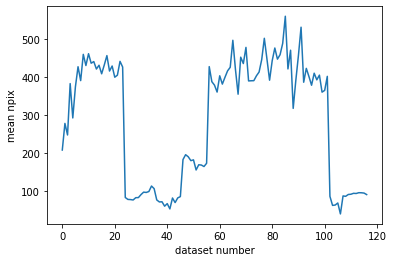

In [35]:
ROI_sizeMean, ROI_sizeStd = [], []

for ii in range(len(sf_list)):
    ROI_npix = np.sum(sf_list[ii][:500]>0, axis=(1,2))
    ROI_sizeMean.append(np.mean(ROI_npix))
    ROI_sizeStd.append(np.std(ROI_npix))
    
%matplotlib inline
plt.figure()
plt.plot(ROI_sizeMean)
plt.xlabel('dataset number');
plt.ylabel('mean npix');

scale_factors = (((1/np.array(ROI_sizeMean))*250)**(1/1.8)) * 0.92
# scale_factors = 1 + ((175/np.array(ROI_sizeMean))**(1.25) -1)/6.5
# scale_factors = [1,1]
print(f'scaling factors: {scale_factors}')

In [36]:
sf_list_rescaled = rescaler(sf_list, scale_factors)
# NPdata_rescaled = rescaler(NPdata, [1.00001, 1.62])

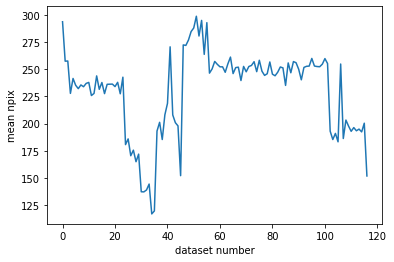

In [37]:
ROI_sizeMean, ROI_sizeStd = [], []

for ii in range(len(sf_list_rescaled)):
    ROI_npix = np.sum(sf_list_rescaled[ii].numpy()>0, axis=(1,2))
    ROI_sizeMean.append(np.mean(ROI_npix))
    ROI_sizeStd.append(np.std(ROI_npix))
    
%matplotlib inline
plt.figure()
plt.plot(ROI_sizeMean)
plt.xlabel('dataset number');
plt.ylabel('mean npix');

<IPython.core.display.Javascript object>


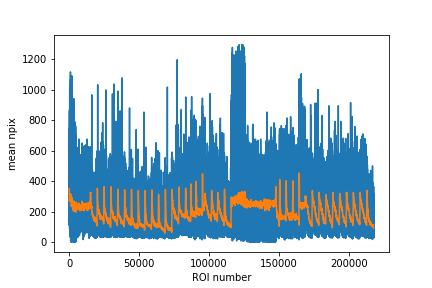

<IPython.core.display.Javascript object>


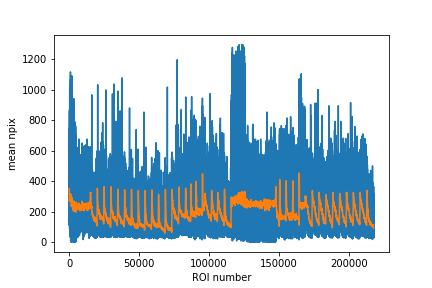

In [38]:
%matplotlib notebook

plt.figure()
plt.plot(np.sum(np.concatenate(sf_list_rescaled) > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(np.concatenate(sf_list_rescaled) > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

plt.figure()
plt.plot(np.sum(np.concatenate(sf_list_rescaled) > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(np.concatenate(sf_list_rescaled) > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

## zero-sum masks

In [39]:
sf_list_rescaled_zeroSum = [sf_list_rescaled[ii] / torch.sum(sf_list_rescaled[ii], dim=(1,2))[:,None,None] for ii in range(len(sf_list_rescaled))]

In [40]:
RHmasks_final = np.concatenate(sf_list_rescaled_zeroSum, axis=0)

## Visualize ROIs

<IPython.core.display.Javascript object>


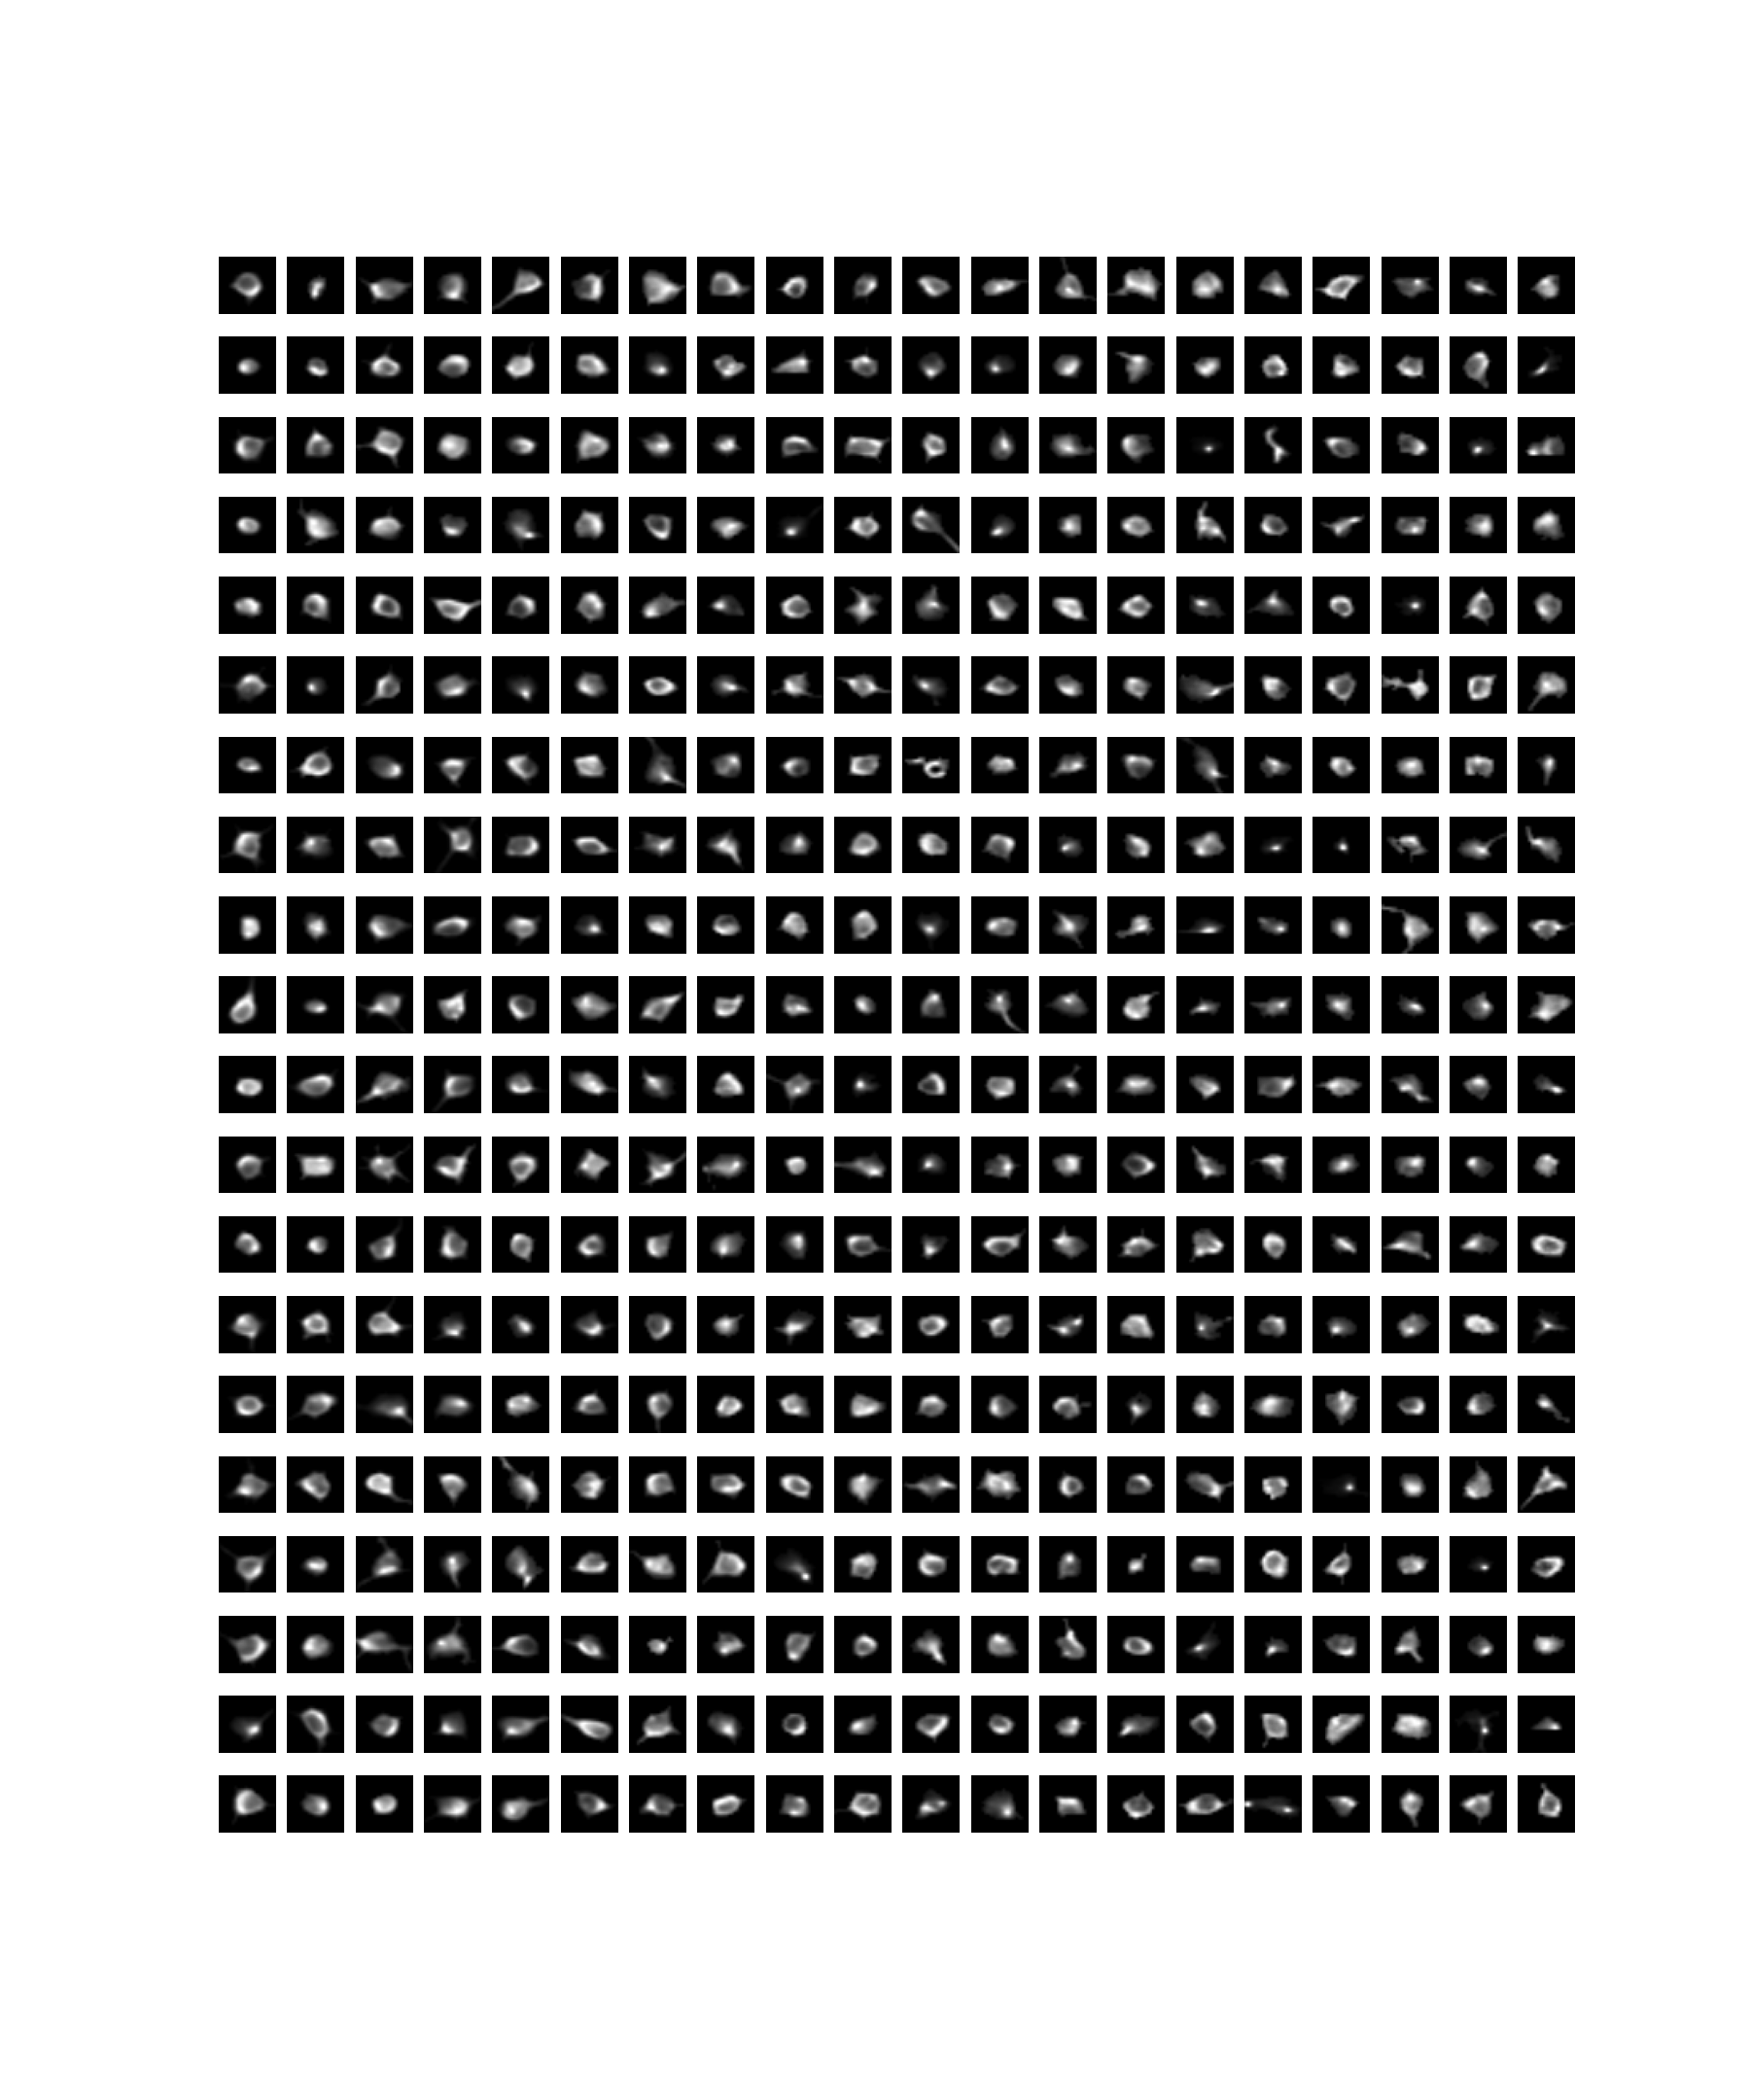

In [41]:
%matplotlib notebook

plotting_helpers.plot_image_grid(images=sf_list_rescaled_zeroSum[30][0:],
#                                 labels=SYTlabels[20000:],
                                grid_shape=(20,20),
                                show_axis='off',
                                cmap='gray',
                                kwargs_subplots={'figsize':(25,30)},
                                kwargs_imshow={'interpolation':'antialiased'});

# Save unbalanced data

In [43]:
h5_handling.simple_save({
    'SYTmasks': SYTmasks_final,
    'SYTlabels': SYTlabels,
    'NPmasks': NPmasks_final,
    'RHmasks': RHmasks_final,
},
                        path='/media/rich/bigSSD RH/other lab data/Harvey_lab_ROIs/masks_20211202.h5',
                        verbose=True,
                        write_mode='w-')

==== Successfully wrote h5 file. Displaying h5 hierarchy ====
1. NPmasks:   shape=(453652, 36, 36) , dtype=float32
2. RHmasks:   shape=(217802, 36, 36) , dtype=float32
3. SYTlabels:   shape=(68382,) , dtype=int64
4. SYTmasks:   shape=(68382, 36, 36) , dtype=float32


# Load data

In [732]:
data = h5_handling.simple_load(path='/media/rich/bigSSD RH/other lab data/Harvey_lab_ROIs/masks_20211202.h5', verbose=True)

1. NPmasks:   shape=(453652, 36, 36) , dtype=float32
2. RHmasks:   shape=(217802, 36, 36) , dtype=float32
3. SYTlabels:   shape=(68382,) , dtype=int64
4. SYTmasks:   shape=(68382, 36, 36) , dtype=float32


In [733]:
# DEVICE = torch_helpers.set_device(use_GPU=True)
masks_cat = torch.as_tensor( np.concatenate((data['SYTmasks'], data['NPmasks'], data['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

## Balance SYT's data

Select a fraction of masks from each label to delete. Code randomly selects indices to delete.

In [51]:
frac_to_delete = [0, 0.7, 0.6, 0.2]

unique_classes = np.unique(SYTlabels)
n_classes = [np.sum(SYTlabels==unique_classes[ii]) for ii in range(len(unique_classes))]
idx_classes = [np.where(SYTlabels==unique_classes[ii])[0] for ii in range(len(unique_classes))]

random_idx_classes = [np.random.choice(idx_classes[ii], size=int(n_classes[ii]*frac_to_delete[ii]), replace=False) for ii in range(len(unique_classes))]

random_idx_classes_cat = np.concatenate(random_idx_classes, axis=0)

idx_balanced_classes = np.delete(np.arange(len(SYTlabels)), random_idx_classes_cat)

<IPython.core.display.Javascript object>


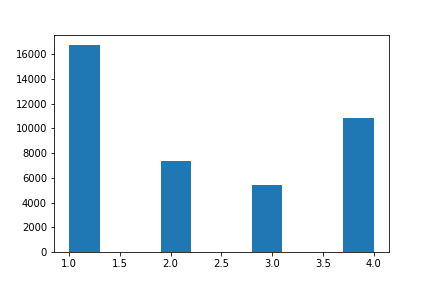

In [53]:
SYTlabels_balanced = SYTlabels[idx_balanced_classes]

plt.figure()
plt.hist(SYTlabels_balanced)

SYTmasks_final_balanced = SYTmasks_final[idx_balanced_classes]

## Save balanced data

In [54]:
h5_handling.simple_save({
    'SYTmasks': SYTmasks_final_balanced,
    'SYTlabels': SYTlabels,
    'NPmasks': NPmasks_final,
    'RHmasks': RHmasks_final,
},
                        path='/media/rich/bigSSD RH/other lab data/Harvey_lab_ROIs/masks_20211202_balanced.h5',
                        verbose=True)

==== Successfully wrote h5 file. Displaying h5 hierarchy ====
1. NPmasks:   shape=(453652, 36, 36) , dtype=float32
2. RHmasks:   shape=(217802, 36, 36) , dtype=float32
3. SYTlabels:   shape=(68382,) , dtype=int64
4. SYTmasks:   shape=(40354, 36, 36) , dtype=float32
